# Anomaly Detection in Network Data using XGBoost
*A compact, demo-friendly notebook for AI@GT.*

**Goal:** Train a fast, explainable binary classifier that flags network anomalies using the `abmallick/network-traffic-anomaly` dataset.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset, Features, Value
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, classification_report, roc_curve
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

# Load data and drop ID columns

In [2]:
features = Features({
    'Dst Port': Value('float64'),
    'Protocol': Value('float64'),
    'Timestamp': Value('string'),
    'Flow Duration': Value('float64'),
    'Tot Fwd Pkts': Value('float64'),
    'Tot Bwd Pkts': Value('float64'),
    'TotLen Fwd Pkts': Value('float64'),
    'TotLen Bwd Pkts': Value('float64'),
    'Fwd Pkt Len Max': Value('float64'),
    'Fwd Pkt Len Min': Value('float64'),
    'Fwd Pkt Len Mean': Value('float64'),
    'Fwd Pkt Len Std': Value('float64'),
    'Bwd Pkt Len Max': Value('float64'),
    'Bwd Pkt Len Min': Value('float64'),
    'Bwd Pkt Len Mean': Value('float64'),
    'Bwd Pkt Len Std': Value('float64'),
    'Flow Byts/s': Value('float64'),
    'Flow Pkts/s': Value('float64'),
    'Flow IAT Mean': Value('float64'),
    'Flow IAT Std': Value('float64'),
    'Flow IAT Max': Value('float64'),
    'Flow IAT Min': Value('float64'),
    'Fwd IAT Tot': Value('float64'),
    'Fwd IAT Mean': Value('float64'),
    'Fwd IAT Std': Value('float64'),
    'Fwd IAT Max': Value('float64'),
    'Fwd IAT Min': Value('float64'),
    'Bwd IAT Tot': Value('float64'),
    'Bwd IAT Mean': Value('float64'),
    'Bwd IAT Std': Value('float64'),
    'Bwd IAT Max': Value('float64'),
    'Bwd IAT Min': Value('float64'),
    'Fwd PSH Flags': Value('float64'),
    'Bwd PSH Flags': Value('float64'),
    'Fwd URG Flags': Value('float64'),
    'Bwd URG Flags': Value('float64'),
    'Fwd Header Len': Value('float64'),
    'Bwd Header Len': Value('float64'),
    'Fwd Pkts/s': Value('float64'),
    'Bwd Pkts/s': Value('float64'),
    'Pkt Len Min': Value('float64'),
    'Pkt Len Max': Value('float64'),
    'Pkt Len Mean': Value('float64'),
    'Pkt Len Std': Value('float64'),
    'Pkt Len Var': Value('float64'),
    'FIN Flag Cnt': Value('float64'),
    'SYN Flag Cnt': Value('float64'),
    'RST Flag Cnt': Value('float64'),
    'PSH Flag Cnt': Value('float64'),
    'ACK Flag Cnt': Value('float64'),
    'URG Flag Cnt': Value('float64'),
    'CWE Flag Count': Value('float64'),
    'ECE Flag Cnt': Value('float64'),
    'Down/Up Ratio': Value('float64'),
    'Pkt Size Avg': Value('float64'),
    'Fwd Seg Size Avg': Value('float64'),
    'Bwd Seg Size Avg': Value('float64'),
    'Fwd Byts/b Avg': Value('float64'),
    'Fwd Pkts/b Avg': Value('float64'),
    'Fwd Blk Rate Avg': Value('float64'),
    'Bwd Byts/b Avg': Value('float64'),
    'Bwd Pkts/b Avg': Value('float64'),
    'Bwd Blk Rate Avg': Value('float64'),
    'Subflow Fwd Pkts': Value('float64'),
    'Subflow Fwd Byts': Value('float64'),
    'Subflow Bwd Pkts': Value('float64'),
    'Subflow Bwd Byts': Value('float64'),
    'Init Fwd Win Byts': Value('float64'),
    'Init Bwd Win Byts': Value('float64'),
    'Fwd Act Data Pkts': Value('float64'),
    'Fwd Seg Size Min': Value('float64'),
    'Active Mean': Value('float64'),
    'Active Std': Value('float64'),
    'Active Max': Value('float64'),
    'Active Min': Value('float64'),
    'Idle Mean': Value('float64'),
    'Idle Std': Value('float64'),
    'Idle Max': Value('float64'),
    'Idle Min': Value('float64'),
    'Label': Value('string'),

    # The extra columns that caused the mismatch:
    'Flow ID': Value('float64'),
    'Src IP': Value('float64'),
    'Src Port': Value('float64'),
    'Dst IP': Value('float64'),
})


# Load the dataset with the specified features
ds = load_dataset("abmallick/network-traffic-anomaly", split="train", features=features)

# Prune unnecessary columns
drop_cols = ['Flow ID', 'Src IP', 'Src Port', 'Dst IP']
ds = ds.remove_columns([c for c in drop_cols if c in ds.column_names])

## Convert to Pandas dataframe for data manipulation

In [3]:
df = ds.to_pandas()
df = df.replace([np.inf, -np.inf], np.nan) 
df.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,443.0,6.0,28/02/2018 08:22:13,94658.0,6.0,7.0,708.0,3718.0,387.0,0.0,118.0,159.284651,1460.0,0.0,531.142857,673.118224,46757.801771,137.336517,7888.166667,11130.042594,24325.0,0.0,72880.0,14576.0,12590.383970,24385.0,363.0,72178.0,12029.666667,13189.257518,24718.0,0.0,0.0,0.0,0.0,0.0,132.0,152.0,63.386085,73.950432,0.0,1460.0,316.142857,519.205881,269574.747253,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,340.461538,118.0,531.142857,0.0,0.0,0.0,0.0,0.0,0.0,6.0,708.0,7.0,3718.0,8192.0,7484.0,3.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,443.0,6.0,28/02/2018 08:22:13,206.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,9708.737864,206.000000,0.000000,206.0,206.0,206.0,206.0,0.000000,206.0,206.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,9708.737864,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,258.0,-1.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2,445.0,6.0,28/02/2018 08:22:15,165505.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,24.168454,55168.333333,95478.146491,165417.0,35.0,165505.0,82752.5,116980.210346,165470.0,35.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,72.0,32.0,18.126341,6.042114,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,8192.0,8192.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
3,443.0,6.0,28/02/2018 08:22:16,102429.0,6.0,7.0,708.0,3718.0,387.0,0.0,118.0,159.284651,1460.0,0.0,531.142857,673.118224,43210.418924,126.917182,8535.750000,10956.637724,24473.0,0.0,80271.0,16054.2,14269.754157,31379.0,366.0,79733.0,13288.833333,14753.482727,30931.0,0.0,0.0,0.0,0.0,0.0,132.0,152.0,58.577161,68.340021,0.0,1460.0,316.142857,519.205881,269574.747253,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,340.461538,118.0,531.142857,0.0,0.0,0.0,0.0,0.0,0.0,6.0,708.0,7.0,3718.0,8192.0,7484.0,3.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
4,443.0,6.0,28/02/2018 08:22:16,167.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,11976.047904,167.000000,0.000000,167.0,167.0,167.0,167.0,0.000000,167.0,167.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,11976.047904,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,258.0,-1.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


### We can better understand the data by reviewing the Label column to see what classifications we have in our dataset.

In [4]:
df['Label'].value_counts()

Label
Benign                      13484708
DDOS attack-HOIC              686012
DDoS attacks-LOIC-HTTP        576191
DoS attacks-Hulk              461912
Bot                           286191
FTP-BruteForce                193360
SSH-Bruteforce                187589
Infilteration                 161934
DoS attacks-SlowHTTPTest      139890
DoS attacks-GoldenEye          41508
DoS attacks-Slowloris          10990
DDOS attack-LOIC-UDP            1730
Brute Force -Web                 611
Brute Force -XSS                 230
SQL Injection                     87
Label                             59
Name: count, dtype: int64

Next we can setup a LabelEncoder to map the classes in our label column to integers for model training.

In [5]:
le = LabelEncoder()
le.fit(df['Label'])
print(le.classes_)

['Benign' 'Bot' 'Brute Force -Web' 'Brute Force -XSS' 'DDOS attack-HOIC'
 'DDOS attack-LOIC-UDP' 'DDoS attacks-LOIC-HTTP' 'DoS attacks-GoldenEye'
 'DoS attacks-Hulk' 'DoS attacks-SlowHTTPTest' 'DoS attacks-Slowloris'
 'FTP-BruteForce' 'Infilteration' 'Label' 'SQL Injection' 'SSH-Bruteforce']


# Split data into training set and test set using a 75:25 ratio.

In [6]:
# capture the labels
labels = df['Label'].copy()

# convert labels to integers
integer_labels = le.transform(labels)
y = integer_labels

# drop the label column from the dataframe (Also timestamp for simplicity)
df = df.copy()
X = df.drop(columns=['Label', 'Timestamp'])

# split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25, 
                                                    random_state=42)

Lets confirm that the shape of our training data is what we expect it to be

In [7]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(12174751, 78)
(12174751,)
(4058251, 78)
(4058251,)


In [8]:
# store preprocessed data and label encoder for later use
preprocessed_data = {
    'x_train':x_train,
    'y_train':y_train,
    'x_test':x_test,
    'y_test':y_test,
    'le':le
}

## Train a Binary Classifier
We will want to convert to binary labels. If the label matches the class "Benign" then it is nominal, else it is considered an anomaly.

In [9]:
def convert_label_to_binary(label_encoder, labels):
    benign_idx = np.where(label_encoder.classes_ == 'Benign')[0][0]
    my_labels = labels.copy()
    my_labels[my_labels != benign_idx] = 1 
    my_labels[my_labels == benign_idx] = 0
    return my_labels

binary_y_train = convert_label_to_binary(le, y_train)
binary_y_test = convert_label_to_binary(le, y_test)

# check how many anomalies are in our labels
print('Number of anomalies in y_train: ', binary_y_train.sum())
print('Number of anomalies in y_test:  ', binary_y_test.sum())

Number of anomalies in y_train:  2061782
Number of anomalies in y_test:   686512


# Hyperparameters

In [10]:
hyperparams = {
    'num_rounds':        10,
    'max_depth':         8,
    'max_leaves':        2**8,
    'alpha':             0.9,
    'eta':               0.1,
    'gamma':             0.1,
    'learning_rate':     0.1,
    'subsample':         1,
    'reg_lambda':        1,
    'scale_pos_weight':  2,
    'tree_method':       'hist',
    'objective':         'binary:logistic',
    'verbose':           True
}

# Binary Classification Model Training

In [11]:
x_train.head()

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
8459598,53.0,17.0,1261.0,1.0,1.0,45.0,61.0,45.0,45.0,45.000000,0.000000,61.0,61.0,61.00,0.0,84060.269627,1586.042823,1261.000000,0.000000e+00,1261.0,1261.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,8.0,8.0,793.021412,793.021412,45.0,61.0,50.333333,9.237604,85.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,75.50,45.000000,61.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,45.0,1.0,61.0,-1.0,-1.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6534254,80.0,6.0,6708524.0,4.0,4.0,97.0,231.0,97.0,0.0,24.250000,48.500000,231.0,0.0,57.75,115.5,48.893020,1.192513,958360.571429,2.508375e+06,6646586.0,43.0,61938.0,20646.0,35485.424064,61621.0,110.0,6708360.0,2236120.0,3.872653e+06,6707874.0,182.0,0.0,0.0,0.0,0.0,92.0,92.0,0.596256,0.596256,0.0,231.0,36.444444,79.699610,6352.027778,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,41.00,24.250000,57.75,0.0,0.0,0.0,0.0,0.0,0.0,4.0,97.0,4.0,231.0,8192.0,141.0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7111845,51035.0,6.0,134.0,3.0,1.0,31.0,0.0,31.0,0.0,10.333333,17.897858,0.0,0.0,0.00,0.0,231343.283582,29850.746269,44.666667,4.051337e+01,90.0,12.0,134.0,67.0,32.526912,90.0,44.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,22388.059701,7462.686567,0.0,31.0,6.200000,13.863621,192.200000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.75,10.333333,0.00,0.0,0.0,0.0,0.0,0.0,0.0,3.0,31.0,1.0,0.0,1187.0,0.0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8866158,53.0,17.0,127700.0,2.0,2.0,56.0,88.0,28.0,28.0,28.000000,0.000000,44.0,44.0,44.00,0.0,1127.642913,31.323414,42566.666667,4.978100e+04,97305.0,1.0,30394.0,30394.0,0.000000,30394.0,30394.0,1.0,1.0,0.000000e+00,1.0,1.0,0.0,0.0,0.0,0.0,16.0,16.0,15.661707,15.661707,28.0,44.0,34.400000,8.763561,76.800000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,43.00,28.000000,44.00,0.0,0.0,0.0,0.0,0.0,0.0,2.0,56.0,2.0,88.0,-1.0,-1.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10215201,443.0,6.0,1046246.0,3.0,3.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00,0.0,0.000000,5.734789,209249.200000,2.706113e+05,507413.0,11595.0,1034651.0,517325.5,2451.539210,519059.0,515592.0,1034600.0,517300.0,2.469217e+03,519046.0,515554.0,0.0,0.0,0.0,0.0,92.0,60.0,2.867394,2.867394,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.00,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,8192.0,0.0,0.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
y_train[0:100]

array([ 0,  0,  0,  0,  0,  0, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       15,  0,  0,  8,  0,  0,  0, 15,  0,  0,  0,  9,  0,  0,  0,  0,  0,
        0,  8,  0,  0,  4,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,
        0,  6,  0,  0,  0,  0,  0, 12,  0,  0,  0,  0,  0,  1,  8,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  4,  8,  0,  0, 11,  0,  8,  0,  0,
        0,  4,  0,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  0])

In [13]:
dtrain = xgb.DMatrix(x_train, label=binary_y_train)
dtest = xgb.DMatrix(x_test, label=binary_y_test)
evals = [(dtest, 'test',), (dtrain, 'train')]

In [14]:
num_rounds = hyperparams['num_rounds']

In [15]:
model = xgb.train(hyperparams, dtrain, num_rounds, evals=evals)

[0]	test-logloss:0.43570	train-logloss:0.43579
[1]	test-logloss:0.38427	train-logloss:0.38431
[2]	test-logloss:0.34218	train-logloss:0.34218
[3]	test-logloss:0.30676	train-logloss:0.30673
[4]	test-logloss:0.27670	train-logloss:0.27664
[5]	test-logloss:0.25087	train-logloss:0.25078
[6]	test-logloss:0.22754	train-logloss:0.22743
[7]	test-logloss:0.20723	train-logloss:0.20710
[8]	test-logloss:0.18946	train-logloss:0.18931
[9]	test-logloss:0.17387	train-logloss:0.17370


In [16]:
threshold = .5
true_labels = binary_y_test.astype(int)
true_labels.sum()

np.int64(686512)

In [17]:
preds = model.predict(dtest)
print(preds)

[0.13055252 0.13055252 0.12424016 ... 0.13055252 0.11405777 0.12407207]


In [18]:
pred_labels = (preds > threshold).astype(int)
print(pred_labels)

[0 0 0 ... 0 0 0]


In [19]:
pred_labels.sum()

np.int64(654375)

# Model Evaluation: Area under the curve

In [20]:
# compute the auc
auc = roc_auc_score(true_labels, preds)
print(auc)

0.9851103320312335


In [22]:
print ('Accuracy:', accuracy_score(true_labels, pred_labels))

Accuracy: 0.9896159700324105


# Model Evaluation: Confusion Matrix

Confusion Matrix :


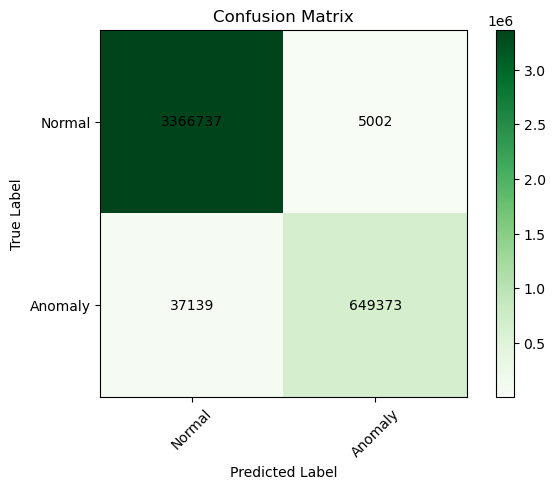

In [23]:
results = confusion_matrix(true_labels, pred_labels) 

print ('Confusion Matrix :')

def plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=plt.cm.Greens):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')


plot_confusion_matrix(results, ['Normal','Anomaly'])